# H2O Uplift Random Forest 

## Modeling Uplift 

Distributed Uplift Random Forest (Uplift DRF) is a classification tool for modeling uplift - the incremental impact of a treatment. This tool is very useful for example in marketing or in medicine. This machine learning approach is inspired by the A/B testing method. 

To model uplift, the analyst needs to collect data specifically - before the experiment, the objects are divided usually into two groups: 

- **treatment group**: receive some kind of treatment (for example customer get some type of discount) 
- **control group**: is separated from the treatment (customers in this group get no discount). 

Then the data are prepared and an analyst can gather information about the response - for example, whether customers bought a product, patients recovered from the disease, or similar. 

## Uplift approaches 

There are several approaches to model uplift: 

- Meta-learner algorithms
- Instrumental variables algorithms
- Neural-networks-based algorithms
- Tree-based algorithms 



## Tree Based Uplift Algorithm

Tree-based algorithm means in every tree, it takes information about treatment/control group assignment and information about response directly into a decision about splitting a node. The uplift score is the criterion to make a decision similar to the Gini coefficient in the standard decision tree. 

**Uplift metric to decide best split**

The goal is to maximize the differences between the class distributions in the treatment and control sets, so the splitting criteria are based on distribution divergences. The distribution divergence is calculated based on the ``uplift_metric`` parameter. In H2O-3, three ``uplift_metric`` types are supported:

- **Kullback-Leibler divergence** (``uplift_metric="KL"``) - uses logarithms to calculate divergence, asymmetric, widely used, tends to infinity values (if treatment or control group distributions contain zero values). 

$ KL(P, Q) = \sum_{i=0}^{N} p_i \log{\frac{p_i}{q_i}}$

- **Squared Euclidean distance** (``uplift_metric="euclidean"``) - symmetric and stable distribution, does not tend to infinity values. 

$ E(P, Q) = \sum_{i=0}^{N} \sqrt{p_i-q_i}$


- **Chi-squared divergence** (``uplift_metric="chi_squared"``) - Euclidean divergence normalized by control group distribution. Asymmetric and also tends to infinity values (if control group distribution contains zero values). 

$\sqrt{X}(P, Q) = \sum_{i=0}^{N} \frac{\sqrt{p_i-q_i}}{q_i}$

where:

- $P$ is treatment group distribution

- $Q$ is control group distribution

In a tree node the result value for a split is sum: $metric(P, Q) + metric(1-P, 1-Q)$. 

For the split gain value, the result within the node is normalized using a gini coefficient (Eclidean or ChiSquared) or entropy (KL) for each distribution before and after the split.


**Uplift score in each leaf is calculated as:**

- $TP = (TY1 + 1) / (T + 2)$
- $CP = (CY1 + 1) / (C + 2)$
- $uplift\_score = TP - CP $

where:
- $T$ how many observations in a leaf are from the treatment group (how many data rows in a leaf have ``treatment_column`` label == 1) 
- $C$ how many observations in a leaf are from the control group (how many data rows in the leaf have ``treatment_column`` label == 0)
- $TY1$ how many observations in a leaf are from the treatment group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 1 and ``response_column`` label == 1)
- $CY1$ how many observations in a leaf are from the control group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 0 and ``response_column`` label == 1)

**Note**: A higher uplift score means more observations from treatment group respond to the offer than from control group. Which means offered treatment has positive effect. The uplift score can be negative, if more observations from control group respond to the offer without treatment.

<br>
<br>

![Difference between SDT and Uplift DT](https://blog.h2o.ai/wp-content/uploads/2022/01/tree.png)




## H2O Implementation (Major release 3.36)

The H2O-3 implementation of Uplift DRF is based on DRF because the principle of training is similar to DRF. It is tree based uplift algorithm. Uplift DRF generates a forest of classification uplift trees, rather than a single classification tree. Each of these trees is a weak learner built on a subset of rows and columns. More trees will reduce the variance. Classification takes the average prediction over all of their trees to make a final prediction. 

Currently, in H2O-3 only binomial trees are supported, as well as the uplift curve metric and Area Under Uplift curve (AUUC) metric and the Qini coefficient. We are working on adding also regression trees and more metrics, for example, normalized AUUC, and more. 

# Start H2O-3

In [4]:
import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import pandas as pd

In [5]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,22 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 13 minutes
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.127 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Load data

To demonstrate how Uplift DRF works, Criteo dataset is used. 

Source: https://www.kaggle.com/arashnic/uplift-modeling

**Description:**

- The dataset was created by The Criteo AI Lab
- Consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions).
- Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks).
- The global treatment ratio is 84.6%.

**Detailed description of the columns:**

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)
- **treatment**: treatment group (1 = treated, 0 = control)
- **conversion**: whether a conversion occured for this user (binary, label)
- **visit**: whether a visit occured for this user (binary, label)
- **exposure**: treatment effect, whether the user has been effectively exposed (binary)

In [18]:
control_name = "control"
treatment_column = "treatment"
response_column = "conversion"
feature_cols = ["f"+str(x) for x in range(0,12)]

df = pd.read_csv("../../smalldata/uplift/criteo_uplift.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


# Prepare data

Inspiration from: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

In [19]:
print('Total number of samples: {}'.format(len(df)))
print('The dataset is largely imbalanced: ')
print(df['treatment'].value_counts(normalize = True))
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Total number of samples: 13979592
The dataset is largely imbalanced: 
1    0.85
0    0.15
Name: treatment, dtype: float64
Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


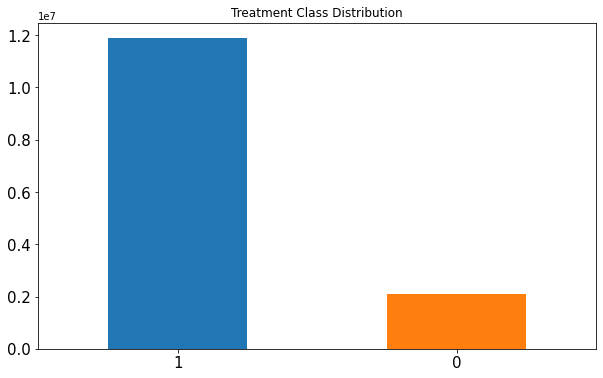

In [20]:
# Print proportion of a binary column
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def print_proportion(df, column):
    fig = plt.figure(figsize = (10,6))
    target_count = df[column].value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
    target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
    plt.xticks(rotation=0) 
    
print_proportion(df, treatment_column)

In [21]:
from sklearn.model_selection import train_test_split
train_df, test_df  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])
print(train_df.shape)
print(test_df.shape)

(11183673, 16)
(2795919, 16)


In [22]:
del(df)

Class 0: 1677550
Class 1: 9506123
Proportion: 6 : 1


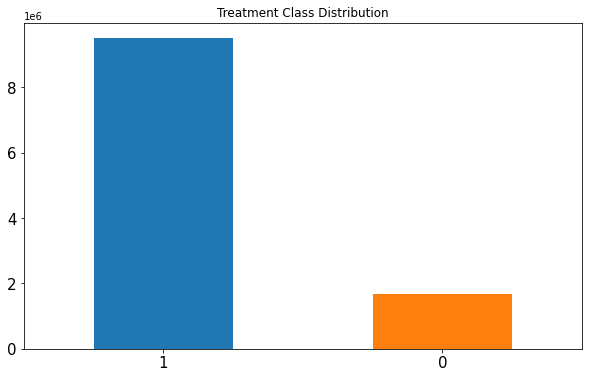

In [23]:
print_proportion(train_df, treatment_column)

In [24]:
# Random Undersampling (finding the majority class and undersampling it)
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [25]:
train_df = random_under(train_df, treatment_column)

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


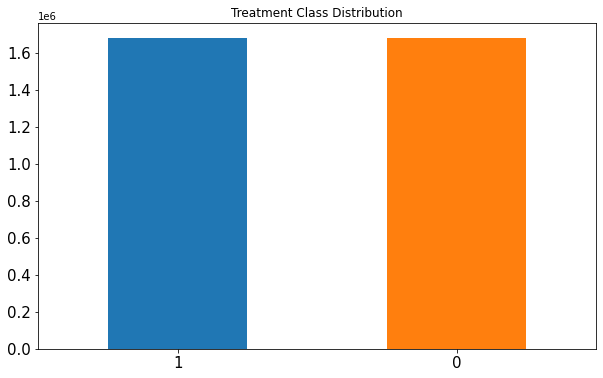

In [26]:
print_proportion(train_df, treatment_column)

## Import data to H2O

In [27]:
h2o_train_df = h2o.H2OFrame(train_df)
del(train_df)

h2o_train_df[treatment_column] = h2o_train_df[treatment_column].asfactor()
h2o_train_df[response_column] = h2o_train_df[response_column].asfactor()

h2o_test_df = h2o.H2OFrame(test_df)

h2o_test_df[treatment_column] = h2o_test_df[treatment_column].asfactor()
h2o_test_df[response_column] = h2o_test_df[response_column].asfactor()
del(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [28]:
ntree = 50
max_depth = 10
metric_h2o="Euclidean"

h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric=metric_h2o,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.80,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=h2o_train_df)
h2o_uplift_model

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1649256196989_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,100.0,102236.0,9.0,9.0,9.0,48.0,107.0,76.86




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 3312.4735745417265

AUUC table: All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,1669.903274,0.003798,3312.473575
1,AUUC random value,954.453216,0.000569,1908.906431


Qini value: 715.4500579887249

AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,715.450058,0.003229,1403.567143



Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc
0,,2022-04-06 16:55:19,0.104 sec,0.0,3813.998863
1,,2022-04-06 16:55:22,2.824 sec,1.0,3199.377520
2,,2022-04-06 16:56:26,1 min 6.967 sec,50.0,3312.473575


# Uplift Curve and Area Under Uplift Curve (AUUC) calculation

To calculate AUUC for big data, the predictions are binned to histograms. Due to this feature the results should be different compared to exact computation.

To define AUUC, binned predictions are sorted from largest to smallest value. For every group the cumulative sum of observations statistic is calculated. The uplift is defined based on these statistics.


## Types of AUUC


| AUUC type | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; Formula &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:----------:|:-------------------------------------------:|
| **Qini**   | $TY1 - CY1 * \frac{T}{C}$                   |
| **Lift**   | $\frac{TY1}{T} - \frac{CY1}{C}$             |
| **Gain**   | $(\frac{TY1}{T} - \frac{CY1}{C}) * (T + C)$ |


Where:

- **T** how many observations are in the treatment group (how many data rows in the bin have treatment_column label == 1)
- **C** how many observations are in the control group (how many data rows in the bin have treatment_column label == 0)
- **TY1** how many observations are in the treatment group and respond to the offer (how many data rows in the bin have treatment_column label == 1 and response_column label == 1)
- **CY1** how many observations are in the control group and respond to the offer (how many data rows in the bin have treatment_column label == 0 and response_column label == 1)


The resulting AUUC value is not normalized, so the result could be a positive number, but also a negative number. A higher number means better model.

For some observation groups the results should be NaN. In this case, the results from NaN groups are linearly interpolated to calculate AUUC and plot uplift curve.


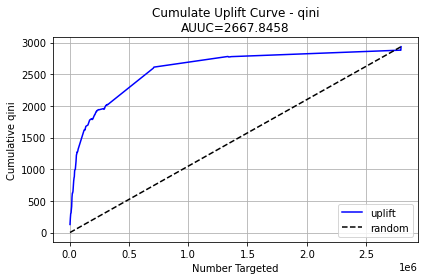

In [29]:
perf_h2o = h2o_uplift_model.model_performance(h2o_test_df)
perf_h2o.plot_uplift(metric="qini")

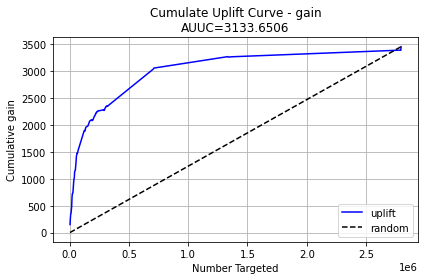

In [30]:
perf_h2o.plot_uplift(metric="gain")

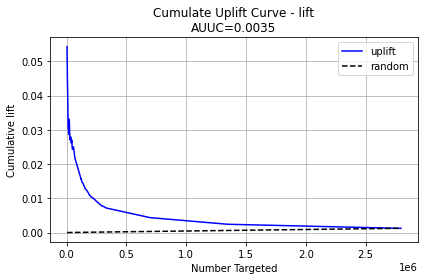

In [31]:
perf_h2o.plot_uplift(metric="lift")

## Normalized AUUC


In [36]:
#perf_h2o.auuc_normalized()
#perf_h2o.plot_uplift(metric="gain", normalize=True)